In [1]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import torch
import torchio

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine as routine
imp.reload(routine)
from utils.routine import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

In [3]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample='pirogov', prefix='fcd', mask='seg', ignore_missing=True,
                         coord_min=(30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path= '../../datasets/fcd_classification_bank',
                         targets_path= 'targets/targets_fcd_bank.csv')

print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))

  0%|          | 0/15 [00:00<?, ?it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:01<00:00,  8.03it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


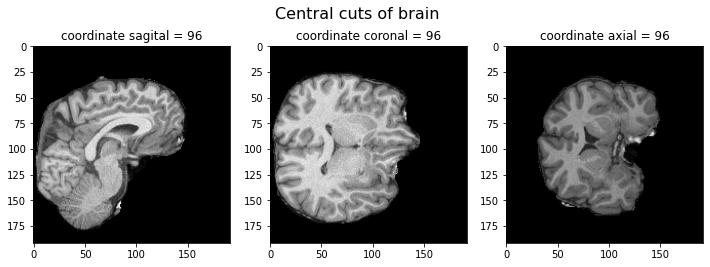

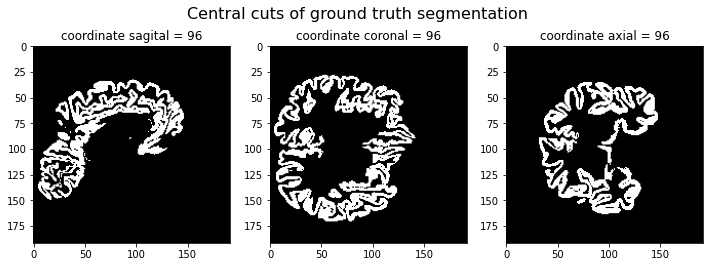

In [4]:
plot_central_cuts(img, 'brain')
plot_central_cuts(seg, 'ground truth segmentation')

### Preprocessing data

In [5]:
# def get_landmarks(data,
#                   indexes,
#                   histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy',
#                   load = True):
#     if load:
#         landmarks = np.load(histogram_landmarks_path)
#     else:
#         image_paths = list(data.img_files[indexes].values)
#         landmarks = HistogramStandardization.train(image_paths, output_path = histogram_landmarks_path)

In [6]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
# for recreating landmarks remove # below 
# image_paths = list(fcd_data.img_files[train_idx].values)
# landmarks = HistogramStandardization.train(image_paths, output_path=histogram_landmarks_path)
landmarks = np.load(histogram_landmarks_path)


training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
    RandomFlip(axes=(0,)),
    OneOf({
        RandomAffine(): 0.8,
        RandomElasticDeformation(): 0.2,
    }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

### Getting torchio preprocessed dataset from data 

In [7]:
dataset = get_torchio_dataset(fcd_pirogov_seg_data.img_files, fcd_pirogov_seg_data.img_seg, training_transform)

In [8]:
dataset.subjects

[Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2)]

### Splitting data into train and test parts 

In [9]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

### Creating dataloaders for model 

In [10]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects


In [11]:
random_batch = next(iter(training_loader))

In [442]:
random_batch['MRI'][DATA]

tensor([[[[[-2.6565, -2.6576, -2.6587,  ..., -2.6884, -2.6885, -2.6887],
           [-2.6550, -2.6562, -2.6573,  ..., -2.6885, -2.6886, -2.6887],
           [-2.6535, -2.6547, -2.6558,  ..., -2.6886, -2.6887, -2.6888],
           ...,
           [-2.6698, -2.6704, -2.6709,  ..., -2.7238, -2.7244, -2.7250],
           [-2.6700, -2.6706, -2.6711,  ..., -2.7233, -2.7239, -2.7245],
           [-2.6703, -2.6708, -2.6714,  ..., -2.7228, -2.7234, -2.7240]],

          [[-2.6566, -2.6577, -2.6588,  ..., -2.6875, -2.6876, -2.6877],
           [-2.6551, -2.6563, -2.6574,  ..., -2.6876, -2.6877, -2.6878],
           [-2.6536, -2.6548, -2.6559,  ..., -2.6877, -2.6878, -2.6879],
           ...,
           [-2.6689, -2.6695, -2.6701,  ..., -2.7231, -2.7237, -2.7243],
           [-2.6692, -2.6697, -2.6703,  ..., -2.7226, -2.7232, -2.7238],
           [-2.6694, -2.6699, -2.6705,  ..., -2.7221, -2.7227, -2.7233]],

          [[-2.6567, -2.6578, -2.6589,  ..., -2.6865, -2.6866, -2.6867],
           [-2.

In [443]:
random_batch['LABEL'][DATA]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

### Getting model and optimizer 

In [12]:
!nvidia-smi

Sat Jan 16 12:47:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   7983MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   31C    P0    32W / 250W |   2961MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [13]:
torch.cuda.set_device(3)

In [14]:
torch.cuda.current_device()

3

In [15]:
torch.cuda.empty_cache()

model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)

In [16]:
model

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): PReLU(num_parameters=1)
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (norm_layer): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): PReLU(num_

In [18]:
def forward(model, input_):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(input_)
    return logits

In [19]:
import enum
import warnings
import torch.nn.functional as F

SPATIAL_DIMENSIONS = 2, 3, 4
CHANNELS_DIMENSION = 1

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    
def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler = False, experiment = False):
    
    '''
    Function 
    
    Arguments:
    
    Output:
    
    '''
    
    is_training = (action == Action.TRAIN)
    epoch_losses = []
    model.train(is_training) #Sets the module in training mode if is_training = True
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            #batch_loss = batch_losses.mean()
            batch_loss = batch_losses
            
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            # appending the loss
            epoch_losses.append(batch_loss.item())
           
#             if experiment:
#                 if action == Action.TRAIN:
#                     experiment.log_metric("train_dice_loss", batch_loss.item())
#                 elif action == Action.VALIDATE:
#                     experiment.log_metric("validate_dice_loss", batch_loss.item())
                    
            del inputs, targets, logits, probabilities, batch_losses
    
    epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    
    return epoch_losses 

In [17]:
inputs, targets = prepare_batch(random_batch, device)

In [17]:
inputs.shape

torch.Size([1, 1, 200, 200, 200])

In [18]:
result = forward(model, inputs)

In [20]:
result.shape

torch.Size([1, 2, 200, 200, 200])

In [19]:
probabilities = F.softmax(result, dim = CHANNELS_DIMENSION)

In [20]:
classes = torch.argmin(probabilities, dim=1)

In [22]:
classes.float()

tensor([[[[0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.]],

         [[0., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 0., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 0., 1., 0.],
          [0., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[0., 1., 1.,  ..., 1., 0., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 1., 

In [26]:
probabilities[probabilities >= 0.5] = 1
probabilities[probabilities != 1] = 0

In [25]:
classes.shape

torch.Size([1, 200, 200, 200])

In [30]:
probabilities

tensor([[[[[0.2606, 0.4920, 0.3834,  ..., 0.4558, 0.4586, 0.5653],
           [0.3645, 0.3865, 0.3319,  ..., 0.4920, 0.5095, 0.4525],
           [0.2192, 0.2915, 0.5049,  ..., 0.5800, 0.6356, 0.6431],
           ...,
           [0.3093, 0.4078, 0.3703,  ..., 0.4236, 0.4369, 0.5218],
           [0.2631, 0.3751, 0.4169,  ..., 0.5900, 0.6339, 0.6123],
           [0.3471, 0.3331, 0.5959,  ..., 0.6288, 0.7042, 0.6482]],

          [[0.2685, 0.4135, 0.3426,  ..., 0.4372, 0.3911, 0.5275],
           [0.4869, 0.3830, 0.4483,  ..., 0.3146, 0.3658, 0.4799],
           [0.1832, 0.2546, 0.4818,  ..., 0.2888, 0.5334, 0.6882],
           ...,
           [0.3073, 0.3915, 0.4005,  ..., 0.4343, 0.5506, 0.6419],
           [0.3132, 0.2462, 0.5761,  ..., 0.5326, 0.6231, 0.7308],
           [0.3857, 0.4141, 0.7470,  ..., 0.6471, 0.7698, 0.8125]],

          [[0.4274, 0.5603, 0.4453,  ..., 0.4418, 0.4040, 0.4073],
           [0.6654, 0.6047, 0.5840,  ..., 0.5890, 0.6220, 0.4329],
           [0.4043, 0.6549

In [68]:
def compute_dice_coefficient(mask_gt, mask_pred, SPATIAL_DIMENSIONS = (2, 3, 4)):
    """Computes soerensen-dice coefficient.

    compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
    and the predicted mask `mask_pred`.

    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
    """
    mask_pred[mask_pred >= 0.5] = 1
    mask_pred[mask_pred != 1] = 0
    mask_pred = mask_pred[:,0,:].reshape(1,1,200,200,200)
    print(mask_pred.shape)
    
    volume_sum = mask_gt.sum(dim = SPATIAL_DIMENSIONS) + mask_pred.sum(dim = SPATIAL_DIMENSIONS)
    print(volume_sum)
    volume_intersect = (mask_gt & mask_pred).sum(dim = SPATIAL_DIMENSIONS)
    return 2*volume_intersect / volume_sum

In [75]:
def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), smoothing = 1e-9):
    '''
    WORKS ONLY IF BATCH_SIZE = 1, I WILL IMPROVE IT LSTER
    
    Function get dice score on output and target tensors  
    https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
    
    Arguments:
        * output (torch.tensor):  (1,2,X,Y,Z) probabilities tensor, one component 
        is probability-tensor (1,X,Y,Z) to be the brain, another component 
        is probability-tensor (1,X,Y,Z) to be background.
        * target (torch.tensor): (1,1,X,Y,Z) binary tensor. 1 - brain mask, 0 - background
        * SPATIAL_DIMENSIONS (typle): typle with indexes corresponding to spatial parts of tensors
        * smoothing (float): a small number to avoid division on zero  
    
    Outputs:
        * dice score (torch.tensor): dice score 
    '''
    output[output >= 0.5] = 1
    output[output != 1] = 0
    output = output[:,0,:].reshape(target.shape)
    
    tp_brain = (output * target).sum(dim=SPATIAL_DIMENSIONS)
    tp_bg = ((1-output) * (1-target)).sum(dim=SPATIAL_DIMENSIONS)
    
    volume_sum_brain = output.sum(dim=SPATIAL_DIMENSIONS) + target.sum(dim=SPATIAL_DIMENSIONS)
    volume_sum_bg = (1-output).sum(dim=SPATIAL_DIMENSIONS) + (1-target).sum(dim=SPATIAL_DIMENSIONS)
    
    dice_brain = 2*tp_brain/(2*volume_sum_brain + smoothing)
    dice_bg = 2*tp_bg/(2*volume_sum_bg + smoothing)
    
    return (dice_brain+dice_bg)/2
    
#     p0 = output
#     g0 = target
#     p1 = 1 - p0
#     g1 = 1 - g0
#     tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
#     fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
#     num = 2 * tp
#     denom = 2 * tp + fp + fn + epsilon
#     dice_score = num / denom
#     return dice_score

def get_dice_loss(output, target):
    '''
    WORKS ONLY IF BATCH_SIZE = 1, I WILL IMPROVE IT LSTER
    
    Function get dice score loss on output and target tensors  
    
    Arguments:
        * output (torch.tensor):  (1,2,X,Y,Z) probabilities tensor, one component 
        is probability-tensor (1,X,Y,Z) to be the brain, another component 
        is probability-tensor (1,X,Y,Z) to be background.
        * target (torch.tensor): (1,1,X,Y,Z) binary tensor. 1 - brain mask, 0 - background
    
    Outputs:
        * dice score loss (torch.tensor): 1 - dice score 
    '''
    return 1 - get_dice_score(output, target)

In [26]:
get_dice_loss(probabilities, targets)

tensor(0.7409, device='cuda:3', grad_fn=<RsubBackward1>)

In [29]:
a = get_dice_loss(probabilities, targets)

In [32]:
a.mean()

tensor(0.8414, device='cuda:3', grad_fn=<MeanBackward0>)

In [73]:
b = get_dice_loss(probabilities, targets)

In [74]:
b

tensor([[0.7919]], device='cuda:3', grad_fn=<RsubBackward1>)

In [70]:
probabilities[0][0].reshape(targets.shape).shape

torch.Size([1, 1, 200, 200, 200])

In [456]:
torch.cuda.empty_cache()

In [453]:
run_epoch(1, Action.TRAIN, training_loader, model, optimizer, scheduler = False, experiment = False)

  0%|          | 0/10 [00:22<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.43 GiB (GPU 3; 15.90 GiB total capacity; 13.57 GiB already allocated; 1.26 GiB free; 13.94 GiB reserved in total by PyTorch)

In [457]:
!nvidia-smi

Sat Jan 16 08:24:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   8758MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |  12082MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T